In [6]:
from torch.utils.tensorboard import SummaryWriter
import torch 
import impaintingLib as imp
from torchvision import transforms
from PIL import Image
import PIL

from torchvision.datasets.folder import ImageFolder
from torch.utils.data import DataLoader

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 0
resize = 3
shuffle = seed == 0
if not shuffle :
    torch.manual_seed(seed)
    
plot = imp.utils.Visu(gridSize=8).plot_img
trainloader, testloader = imp.data.getFaces(shuffle=shuffle,resize=resize)
imgs, _ = next(iter(testloader))
imgs = imgs.to(device)
n,c,w,h = imgs.shape

classif = imp.loss.getTrainedModel()

models = []
models.append(imp.model.UNet(3, netType="partial", convType="gated").to(device))
models.append(imp.model.SubPixelNetwork(3).to(device))
basepath = "./modelSave/gated_conv_UNet(partial_gated)-PixelShuffle1_L1_+_500*perceptualAE_+_perceptualVGG_+_totalvar/"
models[0].load_state_dict(torch.load(basepath + 'UNet(partial gated).pth'))
models[1].load_state_dict(torch.load(basepath + 'PixelShuffle1.pth'))

<All keys matched successfully>

In [ ]:
# Original
imgs = imgs[:8]
plot(imgs)

# Classified
imgT = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(imgs)
classified = classif(imgT)
classified = imp.loss.generate_label(classified,w).to(device)
plot(classified)

# Altered
#alter = imp.mask.Alter(resize=resize,seed=seed).irregularMask
#altered = imp.data.normalize(imgs)
#altered = alter(altered).to(device)
#alteredDisplay = imp.data.inv_normalize(altered)
#plot(alteredDisplay)

# Predicted
#predicted = altered
#for model in models :
#    predicted = model(predicted)
#predicted = imp.data.inv_normalize(predicted)
#plot(predicted)

# Classified 2
#imgT = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(predicted)
#classified2 = classif(imgT)
#classified2 = imp.loss.generate_label(classified2,w).to(device)
#plot(classified2)

transformations = [
     transforms.Resize((120*3,120*3)), 
     transforms.CenterCrop((64*3,64*3)),
     transforms.ToTensor()
]

process = transforms.Compose(transformations)
dataset = ImageFolder("./data/custom", process)
data = DataLoader(dataset, num_workers=0, batch_size=1, shuffle=True)
x,_ = next(iter(data))
x = torch.cat((x,x,x,x,x,x,x,x,x,x,x,x,x,x))
        
plot(x)
imgT = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(x)
imgT = imgT.to(device)
classified = classif(imgT)
classified = imp.loss.generate_label(classified,w).to(device)
plot(classified)

### Classifier sur images

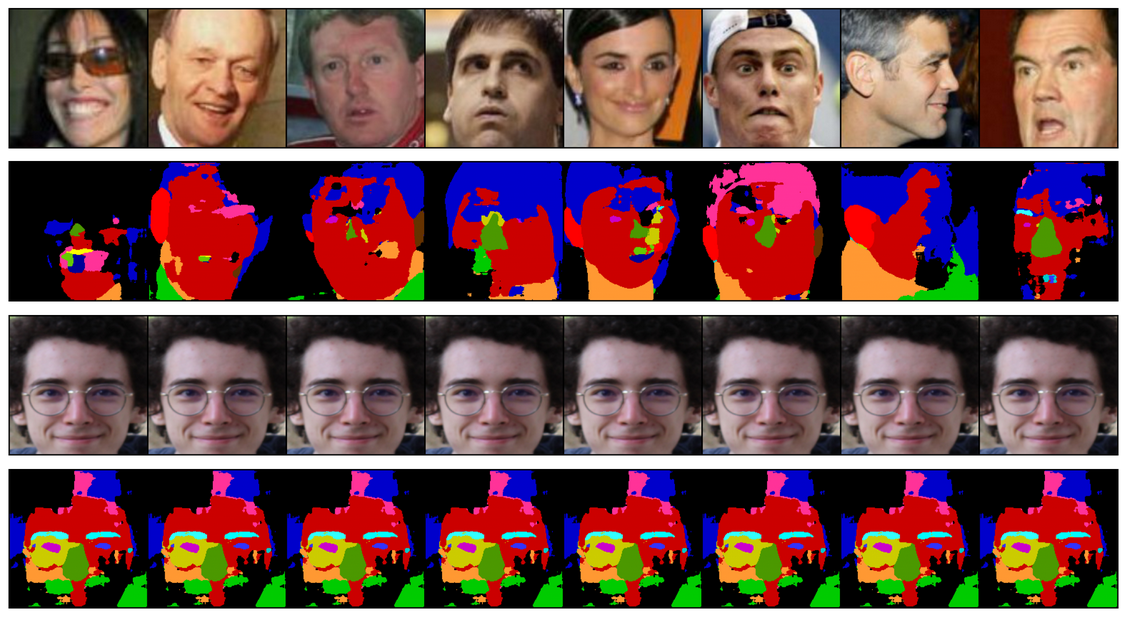

### Classifier sur images originales et prédites

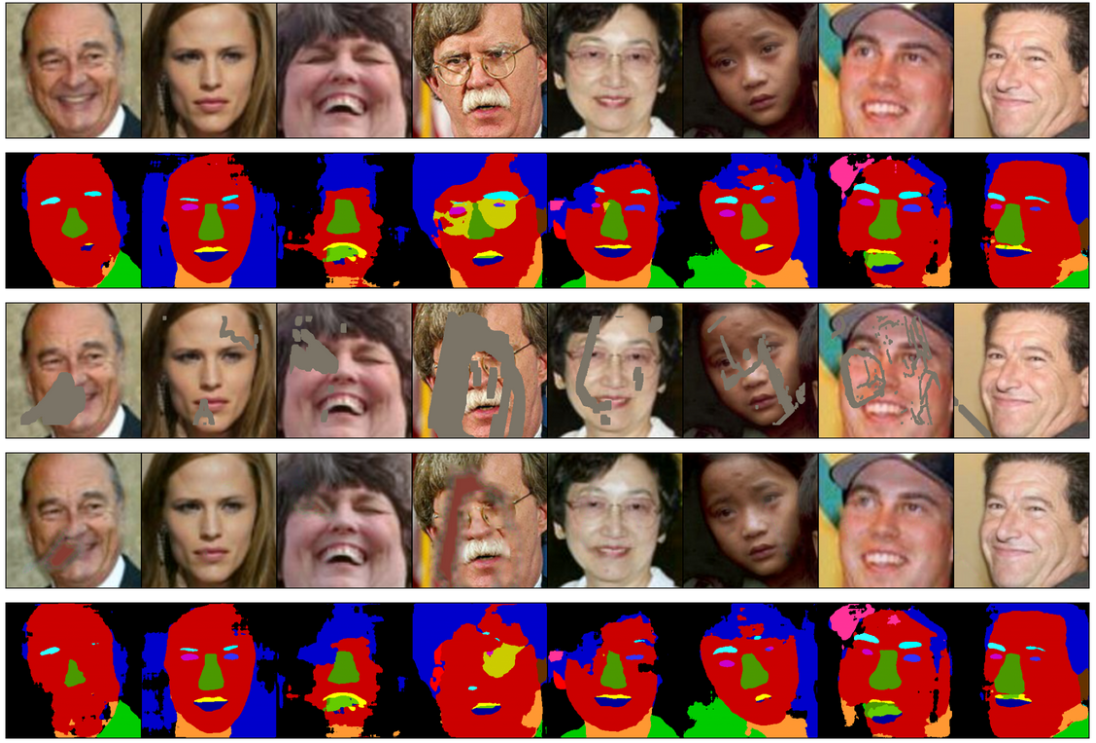

In [33]:
from torch.utils.tensorboard import SummaryWriter
import torch 
import impaintingLib as imp
from torchvision import transforms
from PIL import Image
import PIL
import impaintingLib as imp

from torchvision.datasets.folder import ImageFolder
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 9
#torch.manual_seed(seed)

plot = imp.utils.Visu(gridSize=8).plot_img
lowresize = 1
highresize = 4
factorResize = highresize

In [ ]:
# Original
with torch.no_grad():

    with Image.open("./linkdin.jpg") as image:
        resize = (120*factorResize, 120*factorResize)
        crop   = (64*factorResize, 64*factorResize)
        transformations = transforms.Compose([
             transforms.Resize(resize), 
             transforms.CenterCrop(crop),
             transforms.ToTensor()
        ])
        image = transformations(image)
        c,w,h = image.shape
        x = torch.unsqueeze(image, 0)
        x = torch.cat((x,x,x,x,x,x,x,x,x,x,x,x,x,x))
        
    _, loader = imp.data.getFaces(shuffle=False,resize=factorResize)
    x, _ = next(iter(loader))

    x = x.to(device)
    plot(x)
    xNormalized = imp.data.normalize(x)

    # Add Classifier
    classif = imp.loss.getTrainedModel()
    normalized = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(x)
    classifiedImage = classif(normalized)
    x = torch.cat((xNormalized,classifiedImage),dim=1)

    # Alter
    alter = imp.mask.Alter(resize=factorResize,seed=seed).irregularMask
    x_prime = alter(x)
    alteredDisplay = imp.data.inv_normalize(x_prime[:,:3])
    plot(alteredDisplay)

    # Predict
    model = imp.model.UNet(22, netType="partial", convType="gated").to(device)
    path = './modelSave/partialgated_22channels'
    if factorResize > 1 : 
        path += '_highres'
    path += '.pth'
    model.load_state_dict(torch.load(path))
    x_hat = model(x_prime)
    
    #model = imp.model.SubPixelNetwork(3).to(device)
    #model.load_state_dict(torch.load('./modelSave/pixelshuffle_3channels.pth'))
    #x_hat = model(x_hat)
    
    x_hat = imp.data.inv_normalize(x_hat)
    plot(x_hat)

### Reconstructions avec classifier entrainé sur du 64x64 et 256x256 respectivement
- 15 epochs 64x64
- 5 epochs 128x128
- 5 epochs 192x192
- 3 epochs 256x256

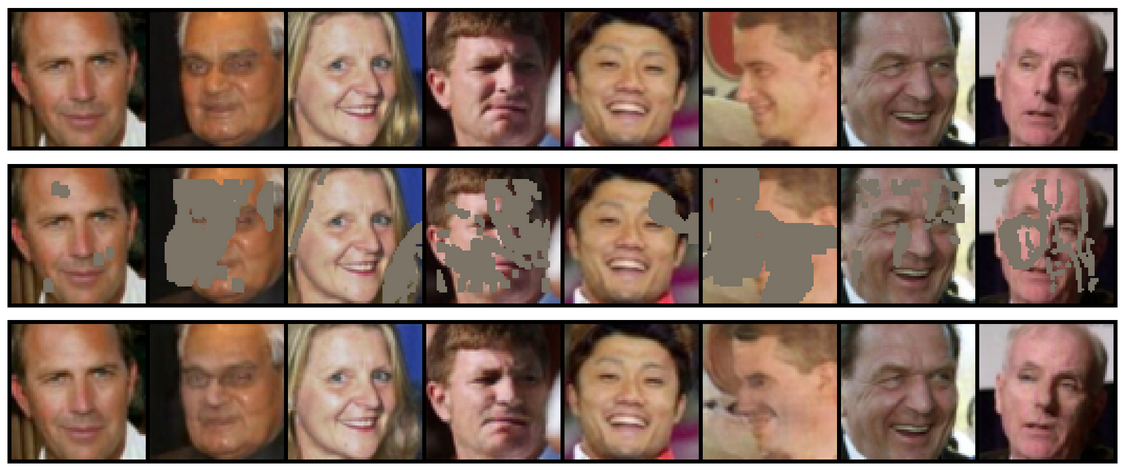

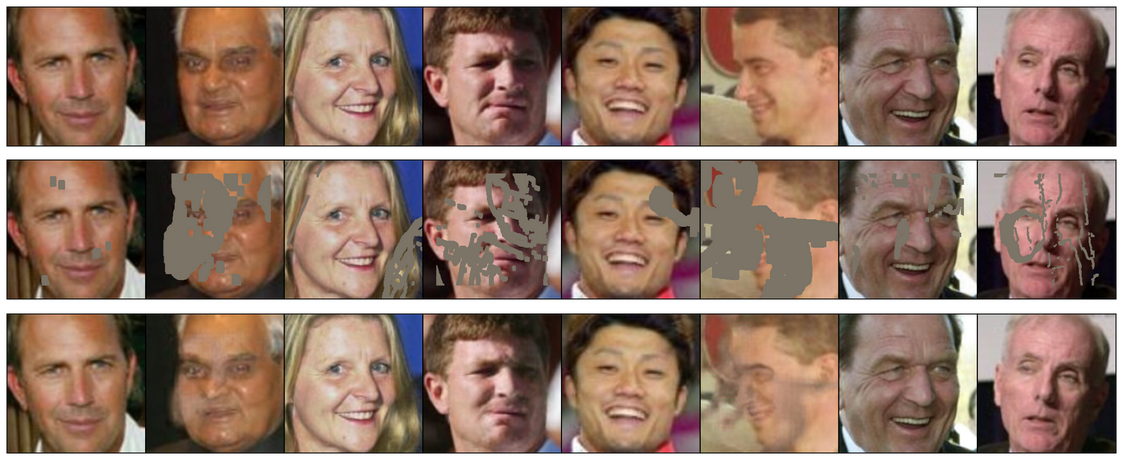

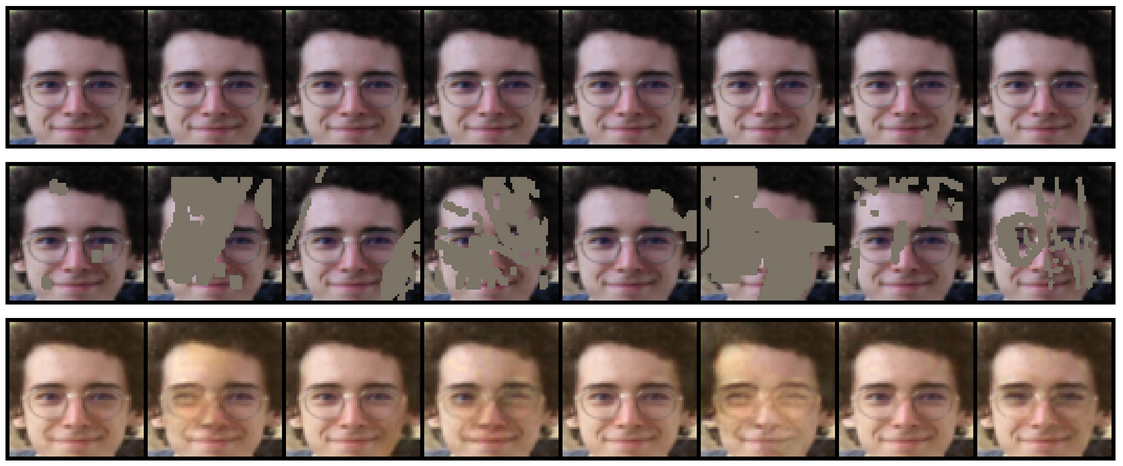

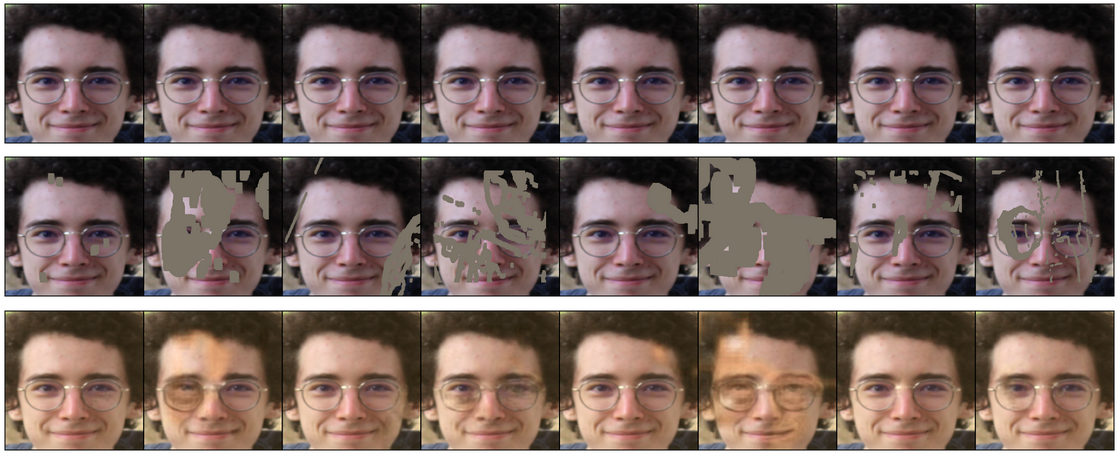

### Avec augmenter subpixel

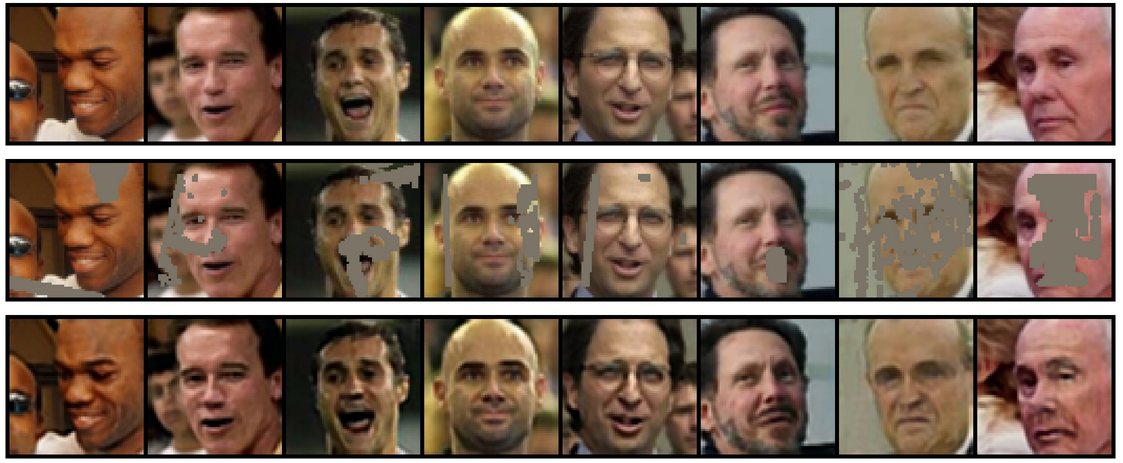

In [2]:
def getModels(basepath):
    models = []
    models.append(imp.model.UNet(3, netType="partial", convType="gated").to(device))
    models.append(imp.model.SubPixelNetwork(3).to(device))
    models[0].load_state_dict(torch.load(basepath + 'UNet(partial gated).pth'))
    models[1].load_state_dict(torch.load(basepath + 'PixelShuffle1.pth'))
    return models

In [ ]:
#------- LOW RESOLUTION

# Original
_, testloaderLow = imp.data.getFaces(shuffle=False,resize=lowresize)
imgsLow, _ = next(iter(testloaderLow))
imgsLow = imgsLow.to(device)
#plot(imgsLow)

# Alter
alter = imp.mask.Alter(resize=lowresize,seed=seed).irregularMask
altered = imp.data.normalize(imgsLow)
altered = alter(altered)
alteredDisplay = imp.data.inv_normalize(altered)
#plot(alteredDisplay)

# Predict
models = getModels("./modelSave/gated_conv_UNet(partial_gated)-PixelShuffle1_L1_+_500*perceptualAE_+_perceptualVGG_+_totalvar/")
predicted = altered
for model in models :
    predicted = model(predicted)
predicted = imp.data.inv_normalize(predicted)
plot(predicted)

#------- HIGH RESOLUTION

# Original
_, testloaderHigh = imp.data.getFaces(shuffle=False,resize=highresize)
imgsHigh, _ = next(iter(testloaderHigh))
imgsHigh = imgsHigh.to(device)
#plot(imgsHigh)

# Alter
alter = imp.mask.Alter(resize=highresize,seed=seed).irregularMask
altered = imp.data.normalize(imgsHigh)
altered = alter(altered)
alteredDisplay = imp.data.inv_normalize(altered)
plot(alteredDisplay)

# Predict
models = getModels("./modelSave/gated_conv_UNet(partial_gated)-PixelShuffle1_L1_+_500*perceptualAE_+_perceptualVGG_+_totalvar/")
predicted = altered
for model in models :
    predicted = model(predicted)
predicted = imp.data.inv_normalize(predicted)
plot(predicted)